# Predecir la promoción de un empleado



* Limpieza/preprocesamiento  
* Clases desbalanceadas
*   Keras-tuner




Dataset

https://www.kaggle.com/code/muhammadimran112233/employee-promotion-end-to-end-solution/input


incluir, al menos, lo siguiente


* Manejo de datos faltantes
* datos repetidos
* columnas constantes
* ¿hay outliers?
* ¿selección de atributos?
* estandarización de datos
* Manejo de datos desbalanceados
* Keras-tuner, usar conjunto de validación
  * construir modelo con los mejores parámetros
  * graficar loss y acc de train y validación
  * evaluar con X_test
  * obtener matriz de confusión

# Importando Dataset y Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./employee_promotion.csv')

# Análisis Exploratorio de datos

Tenemos las siguientes columnas

- **department**: Departamento del empleado  
- **region**: Región de empleo (no ordenada)  
- **education**: Nivel educativo  
- **gender**: Género del empleado  
- **recruitment_channel**: Canal de reclutamiento del empleado  
- **no_of_trainings**: Número de capacitaciones adicionales completadas el año anterior (habilidades blandas, técnicas, etc.)  
- **age**: Edad del empleado  
- **previous_year_rating**: Calificación del empleado en el año anterior  
- **length_of_service**: Antigüedad en años de servicio  
- **awards_won**: Si ganó premios el año anterior → 1, de lo contrario 0  
- **avg_training_score**: Puntaje promedio en evaluaciones de capacitaciones actuales  
- **is_promoted**: **(Variable objetivo)** Si fue recomendado para promoción  

Como vemos hay varios preguntas que tenemos que hacernos de primera mano, ¿Necesitamos el número de empleado?, ¿Tener el genero es necesario, habra un cesgo en los datos hacia los hombres para hacer las promociones?

In [3]:
df.shape

(54808, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


Al parecer solo las columnas avg_training_score, education, previous_year_rating son las que tienen valores nulos, el porcentaje son minimo entonces tal vez sea buena idea imputarlas

In [5]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,52248.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.023172,63.712238,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.150450,13.521910,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,0.000000,77.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


In [6]:
df.head(10)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
5,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,85.0,0
6,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,59.0,0
7,16290,Operations,region_34,Master's & above,m,sourcing,1,33,3.0,6,0,63.0,0
8,73202,Analytics,region_20,Bachelor's,m,other,1,28,4.0,5,0,83.0,0
9,28911,Sales & Marketing,region_1,Master's & above,m,sourcing,1,32,5.0,5,0,54.0,0


Tenemos como columnas categóricas a:
- department
- region
- educacion
- genero
- recruiment_chanel
- awards_won

El resto son columnas numericas.

In [7]:
# Convertir todas las columnas object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# Convertir awards_won a category
df['awards_won'] = df['awards_won'].astype('category')

Vemos si hay filas repetidas

In [8]:
df.duplicated().sum()

np.int64(0)

Vamos a ver filas con valores nulos

In [9]:
df.isnull().sum() / df.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
awards_won              0.000000
avg_training_score      4.670851
is_promoted             0.000000
dtype: float64

Vamos a ver si hay sesgo al momento de promocionar a alguien por el genero.

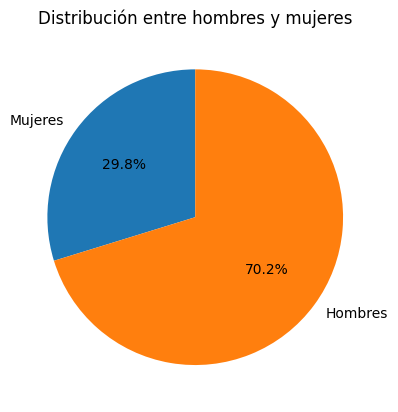

In [10]:
values_counts = df[['gender']].value_counts()
number_men = values_counts['m']
number_women = values_counts['f']

labels = ['Mujeres', 'Hombres']

plt.pie([number_women, number_men], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre hombres y mujeres')
plt.show()





Vemos que aproximadamente el 70% de las personas son hombres y 30% mujeres, vamos a ver si se conserva esta proporcion al momento de promocionar a alguien

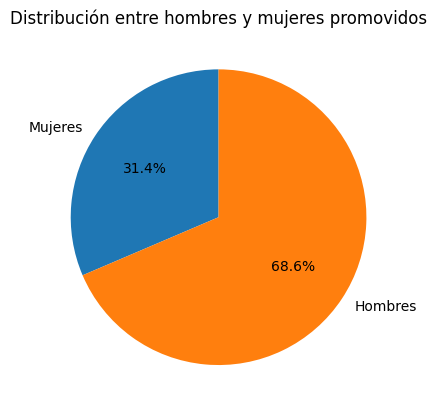

In [11]:
df_promoted = df[df['is_promoted'] == 1]
df_promoted.groupby('is_promoted')['gender'].value_counts()

number_men_promoted = len(df_promoted[df_promoted['gender'] == 'm'])
number_women_promoted = len(df_promoted[df_promoted['gender'] == 'f'])

labels = ['Mujeres', 'Hombres']

plt.pie([number_women_promoted, number_men_promoted], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre hombres y mujeres promovidos')
plt.show()

Vemos que no hay un sesgo al momento de promover a un empleado por su genero

Ahora vamos a ver la distribucion de nuestras variables

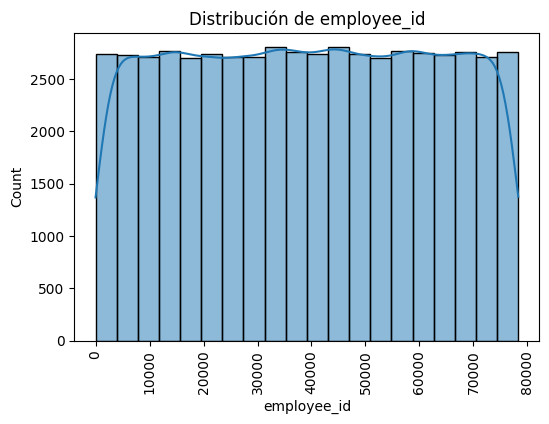

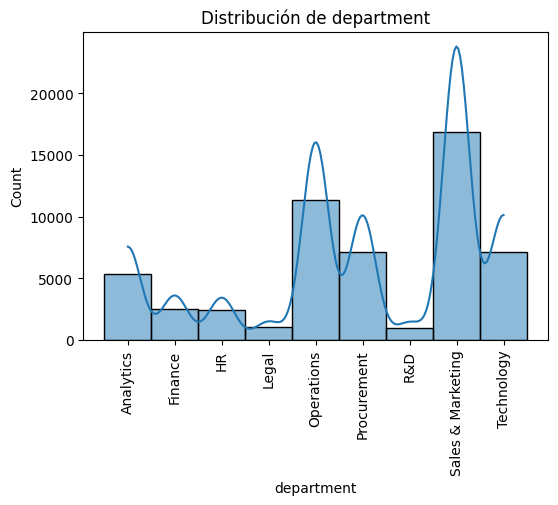

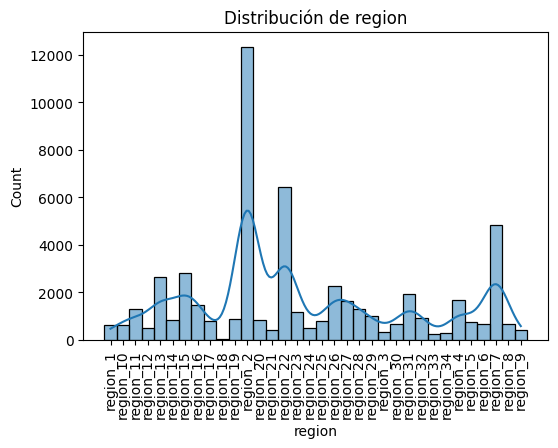

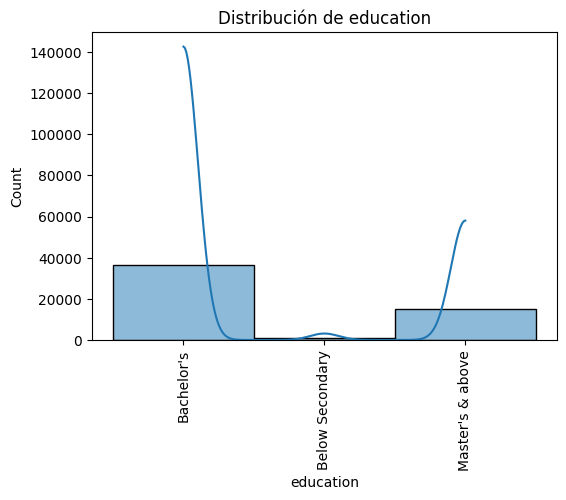

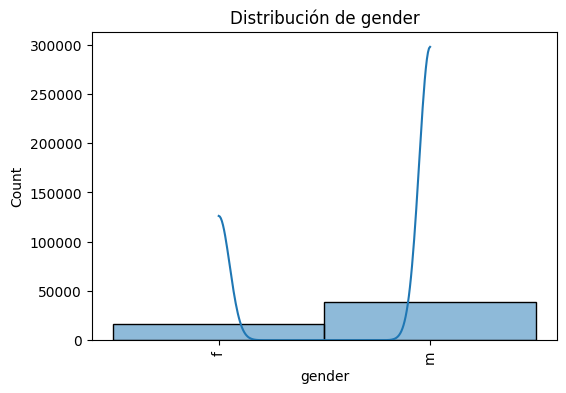

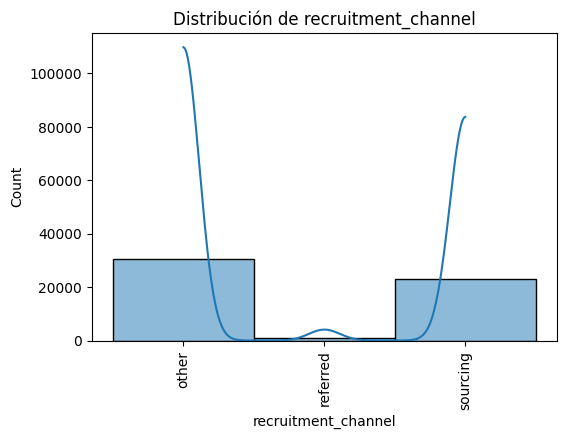

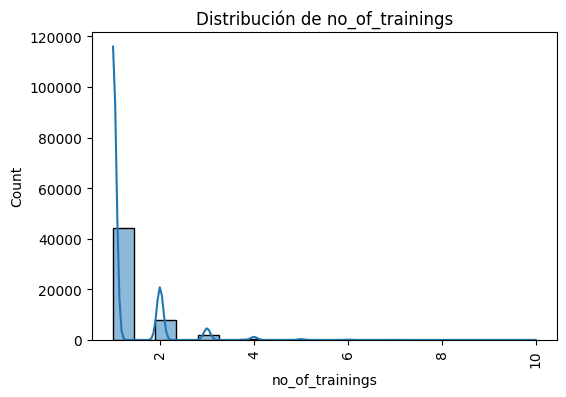

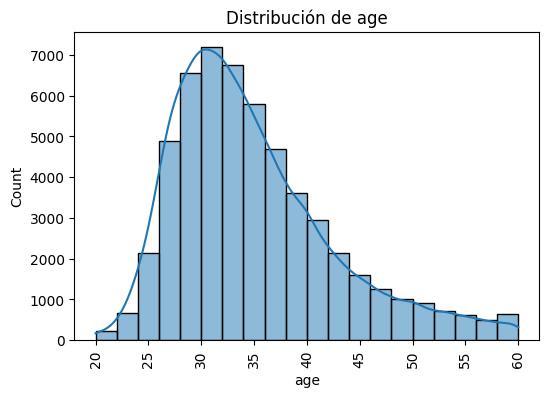

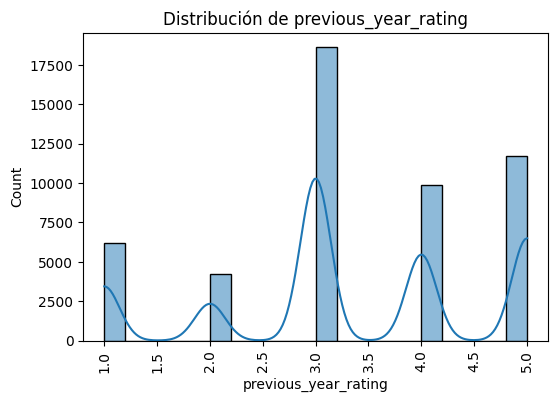

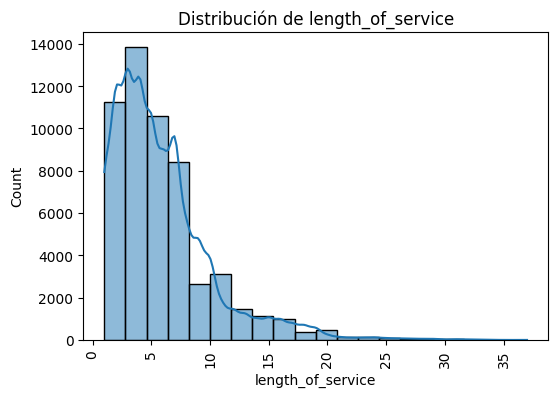

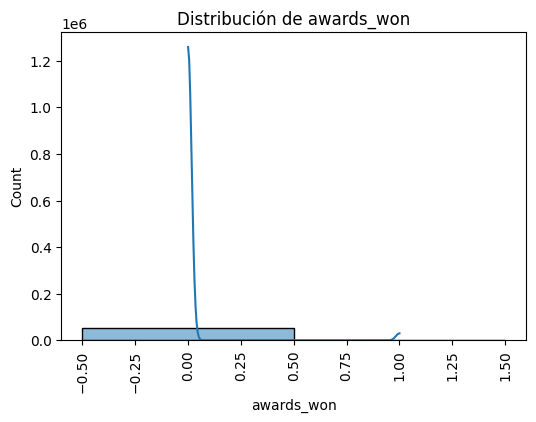

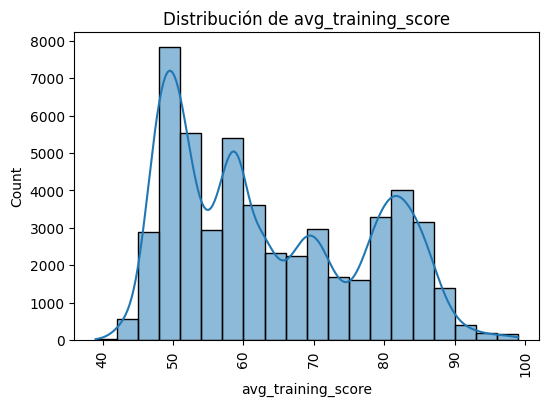

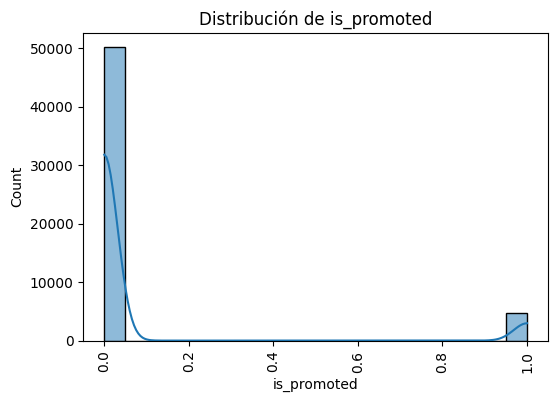

In [12]:
for col in df.columns:
    plt.figure(figsize=(6,4))
    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col)
        plt.title(f"Distribución de {col}")
    else:  # numéricas
        sns.histplot(data=df, x=col, kde=True, bins=20)
        plt.title(f"Distribución de {col}")
    plt.xticks(rotation=90)
    plt.show()


Vemos que tenemos clases desbalanceadas, si nos fijamos en la variable "is_promoted"

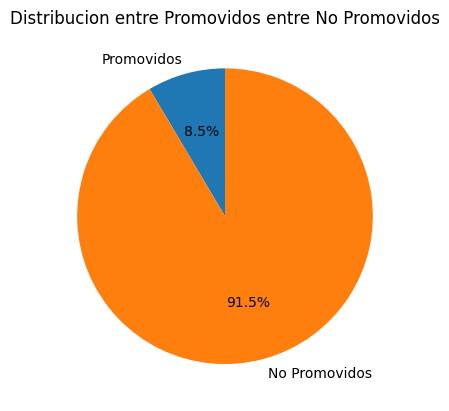

In [13]:
labels = ['Promovidos', 'No Promovidos']

promoted = len(df[df['is_promoted'] == 1])
no_promoted = df.shape[0] - promoted
plt.pie([promoted, no_promoted], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribucion entre Promovidos entre No Promovidos')
plt.show()

Ahora vamos a ver nuestros datos con respecto a nuestra variable objetiva

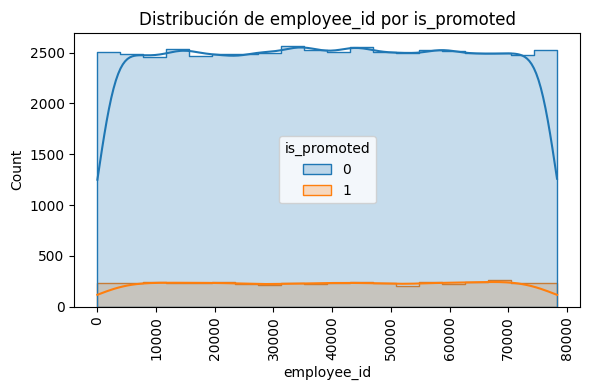

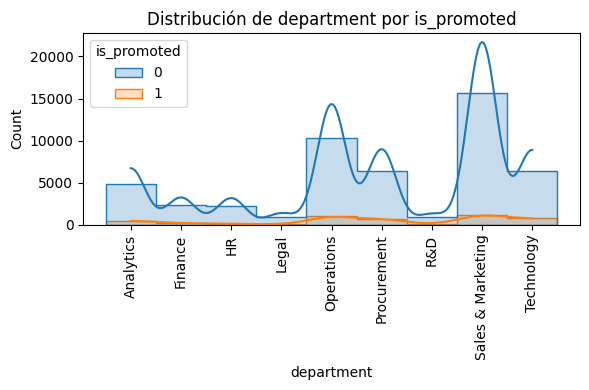

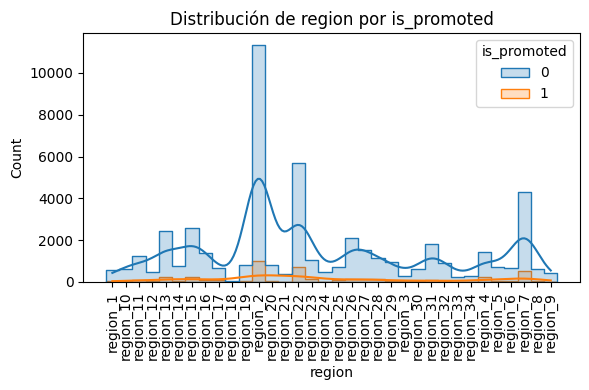

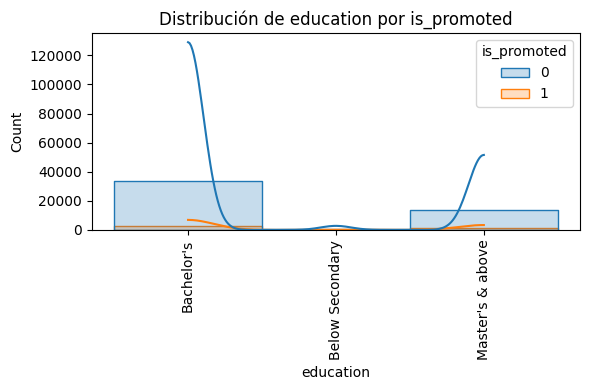

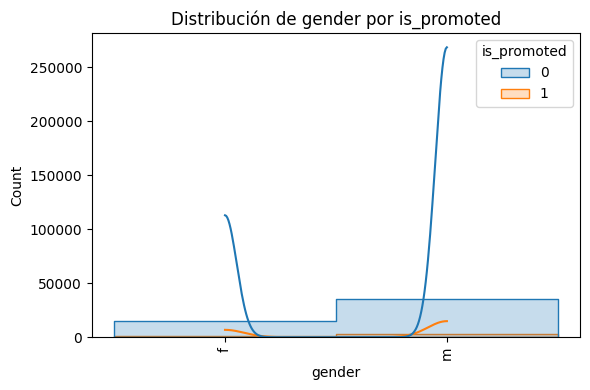

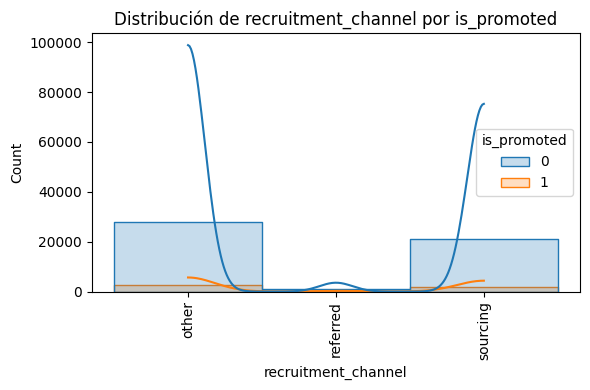

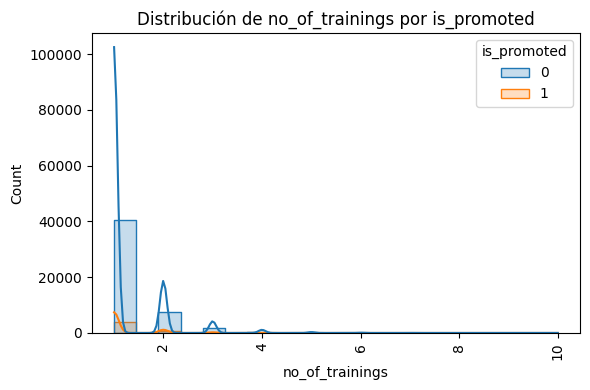

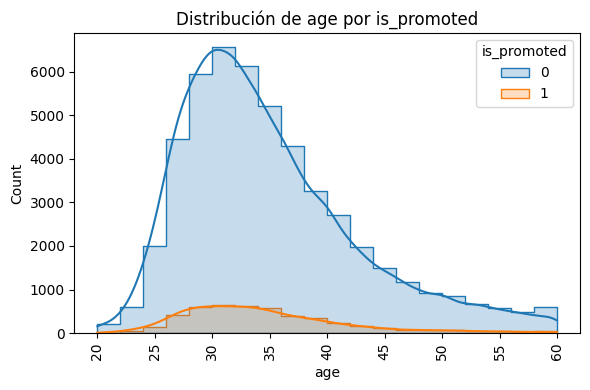

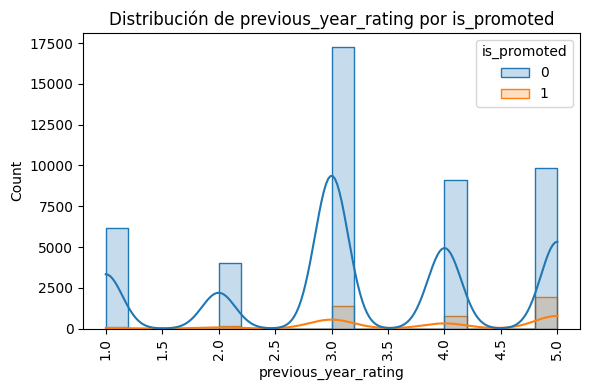

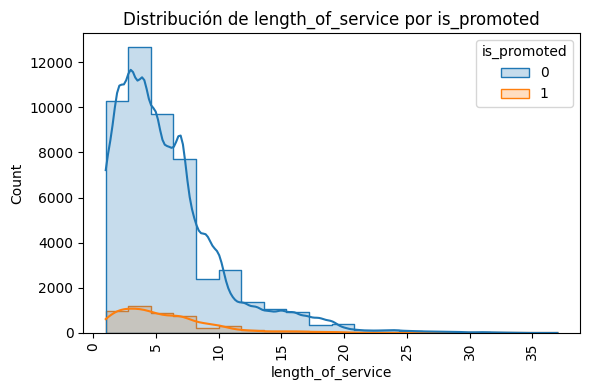

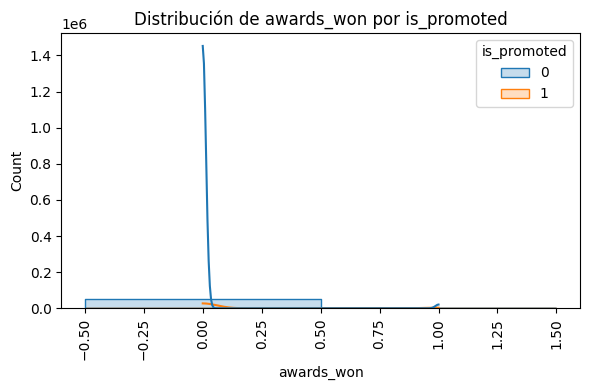

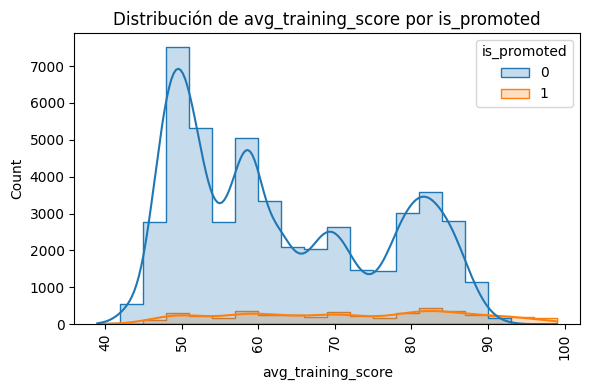

In [14]:
target = "is_promoted"

for col in df.columns:
    if col == target:
        continue

    plt.figure(figsize=(6,4))

    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f"Distribución de {col} por {target}")
    else:  # numéricas
        sns.histplot(data=df, x=col, hue=target, kde=True, bins=20, element="step")
        plt.title(f"Distribución de {col} por {target}")

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Al parecer todas las variables tienen relación, lo único que quitaremos por el momento es el número de empleado que no nos sirve de nada para el modelo.

In [15]:
df.drop('employee_id', axis=1, inplace=True)

Vamos a ver que columnas tienen outliers

In [16]:
numeric_cols = list(df.select_dtypes(include="number"))
numeric_cols.remove("is_promoted")

prop_outliers = {}
for c in numeric_cols:
  q1 = df[c].dropna().quantile(.25)
  q3 = df[c].dropna().quantile(.75)
  IQR = q3 - q1

  lower = q1 - 1.5*IQR
  high = q3 + 1.5*IQR

  prop_outliers[c] = df[(df[c] < lower) | (df[c] > high)].shape[0] / df.shape[0] * 100

for k,v in prop_outliers.items():
  print(f"La columna {k} tiene {v}% de outliers")


La columna no_of_trainings tiene 19.03006860312363% de outliers
La columna age tiene 2.618230915194862% de outliers
La columna previous_year_rating tiene 11.354181871259671% de outliers
La columna length_of_service tiene 6.365858998686323% de outliers
La columna avg_training_score tiene 0.0% de outliers


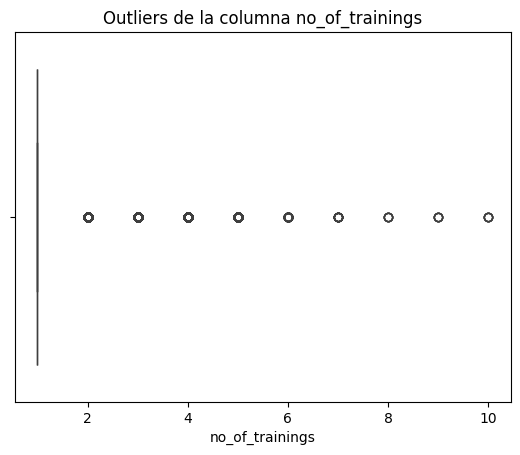

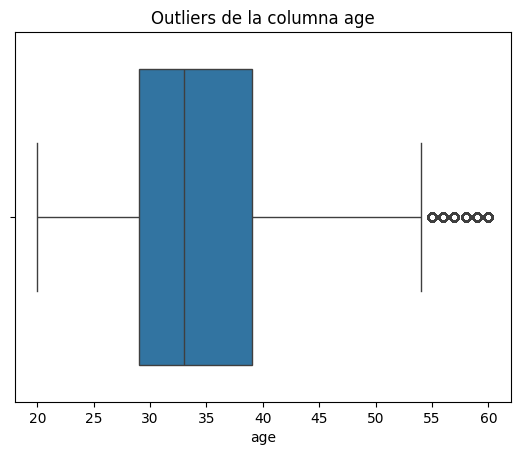

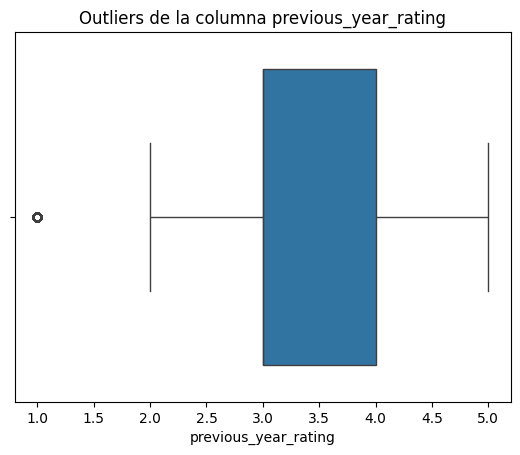

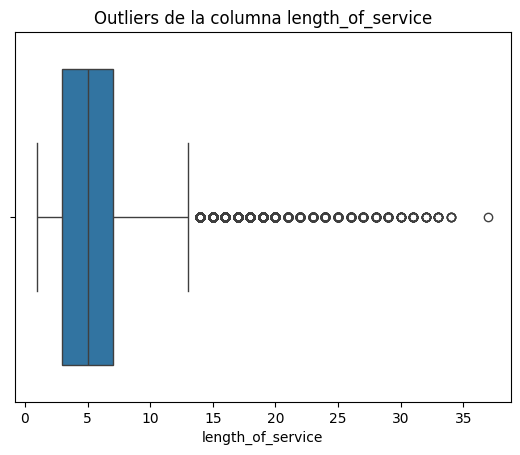

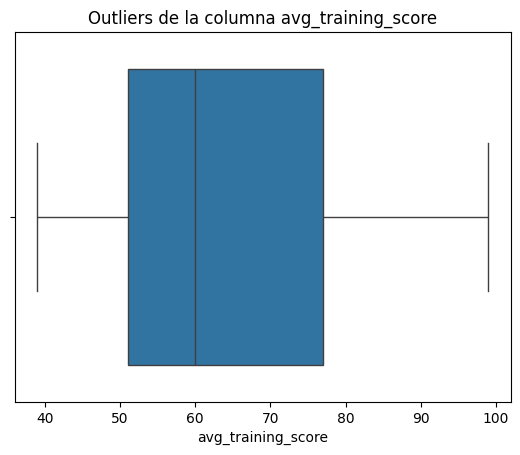

In [17]:
for c in numeric_cols:
  sns.boxplot(data=df, x=c)
  plt.title(f"Outliers de la columna {c}")
  plt.show()

Vemos que si hay outliers, pero no son por errores de medición, ahora vamos a ver si hay sesgo.

In [18]:
skews = {}
for c in numeric_cols:
  skews[c] = df[c].skew()

for k,v in skews.items():
  print(f"la columna {k} tiene un sesgo de {v}")

la columna no_of_trainings tiene un sesgo de 3.445433937567454
la columna age tiene un sesgo de 1.0074317710382241
la columna previous_year_rating tiene un sesgo de -0.3106378431385327
la columna length_of_service tiene un sesgo de 1.738061458740809
la columna avg_training_score tiene un sesgo de 0.4191534330632933


Vemos que son algunas columnas las que tienen  sesgo, entonces tambien hay que corregirlo.

## Dividiendo el dataset

In [19]:
X = df.drop('is_promoted', axis=1)
y = df[['is_promoted']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

## Preprocesamiento de Datos

### Imputando datos

Vamos a imputar los datos de las columnas avg_training_score, education, previous_year_rating que eran las que tenian valores faltantes.

In [20]:

median = X_train['previous_year_rating'].median()
X_train['previous_year_rating'].fillna(median, inplace=True)
X_test['previous_year_rating'].fillna(median, inplace=True)
X_test['previous_year_rating'].fillna(median, inplace=True)

mean = X_train['avg_training_score'].mean()
X_train['avg_training_score'].fillna(mean, inplace=True)
X_test['avg_training_score'].fillna(mean, inplace=True)
X_val['avg_training_score'].fillna(mean, inplace=True)

mode = X_train['education'].mode()[0]
X_train['education'].fillna(mode, inplace=True)
X_test['education'].fillna(mode, inplace=True)
X_val['education'].fillna(mode, inplace=True)

/tmp/ipykernel_116811/3393944138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['previous_year_rating'].fillna(median, inplace=True)
/tmp/ipykernel_116811/3393944138.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Vamos a ver si podemos eliminar columnas que no nos sean tan utiles. Vamos a ver por correlaciones en columnas.

In [21]:
# Correlaciones con el target

Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train_num = Xy_train.select_dtypes(include="number")

corrs = Xy_train_num.corr(method="pearson")["is_promoted"].sort_values(ascending=False)

print(corrs)

is_promoted             1.000000
avg_training_score      0.181495
previous_year_rating    0.153849
length_of_service      -0.012608
age                    -0.021045
no_of_trainings        -0.025986
Name: is_promoted, dtype: float64


In [22]:
# Veamos correlacion pero de las personas que fueron promocionadas
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train_num_promoted = Xy_train_num[Xy_train_num['is_promoted'] == 1].select_dtypes(include="number")

corrs = Xy_train_num.corr(method="pearson")["is_promoted"].sort_values(ascending=False)

Vemos que no cambia mucho las variables relacionadas con los que estan promovidos

Las que mas tienen correlacion con el target son avg_training_score y previous_year_rating.

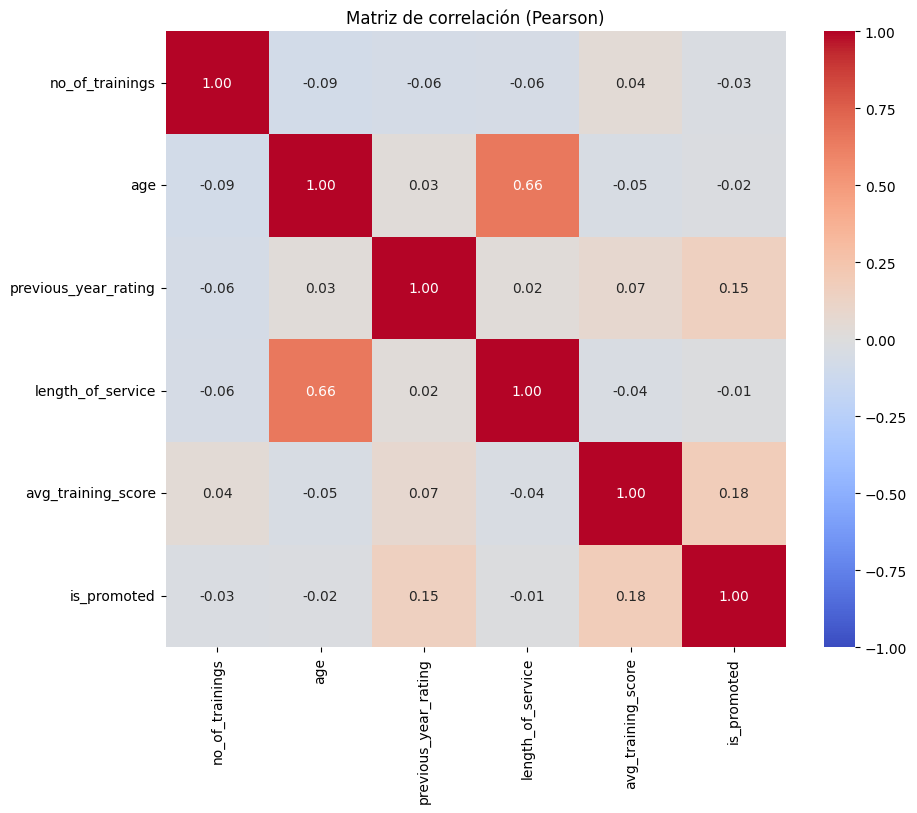

In [23]:
corr_matrix = Xy_train_num.corr(method="pearson")

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación (Pearson)")
plt.show()

Vemos que edad y años de servicio tienen una alta correlacion, vamos a quedarnos con la de años de servicio.

In [24]:
X_train.drop('age', axis=1, inplace=True)
X_test.drop('age', axis=1, inplace=True)
X_val.drop('age', axis=1, inplace=True)

Voy a eliminar tambien la variable 'genero', ya vimos que no hay correlacion y no quiero que el modelo analice el genero.

In [25]:
X_train.drop('gender', axis=1, inplace=True)
X_test.drop('gender', axis=1, inplace=True)
X_val.drop('gender', axis=1, inplace=True)

### Tratando Outliers

Vimos que es poco probable que los outliers se deban a errores, haremos winsorizacion.

In [26]:
columns_with_outliers = [
    "no_of_trainings",
    "previous_year_rating",
    "length_of_service"
]

for c in columns_with_outliers:
    lower = X_train[c].quantile(0.01)
    upper = X_train[c].quantile(0.99)
    X_train[c + "_wins"] = X_train[c].clip(lower, upper)
    X_test[c + "_wins"] = X_test[c].clip(lower, upper)
    X_val[c + "_wins"] = X_val[c].clip(lower, upper)


Veamos si se conserva el sesgo en nuestras variables

In [27]:
skews = {}
for c in X_train.select_dtypes(include='number').columns:
  skews[c] = X_train[c].skew()

for k,v in skews.items():
  print(f"la columna {k} tiene un sesgo de {v}")

la columna no_of_trainings tiene un sesgo de 3.3554278492192924
la columna previous_year_rating tiene un sesgo de -0.2624439382826854
la columna length_of_service tiene un sesgo de 1.7348228027480619
la columna avg_training_score tiene un sesgo de 0.4308494071522068
la columna no_of_trainings_wins tiene un sesgo de 2.608794125789331
la columna previous_year_rating_wins tiene un sesgo de -0.2624439382826854
la columna length_of_service_wins tiene un sesgo de 1.3694515845065056


### Corrigiendo Sesgo

In [28]:
skews_columns = [
    "no_of_trainings_wins",
    "length_of_service_wins"
]

boxcox_cols = []
yeojohnson_cols = []

for c in skews_columns:
    min_val = X_train[c].min()
    if min_val > 0:
        boxcox_cols.append(c)
    else:
        yeojohnson_cols.append(c)

print("Columnas que se pueden transformar con Box-Cox:")
print(boxcox_cols)

print("\nColumnas que se deben transformar con Yeo-Johnson:")
print(yeojohnson_cols)


Columnas que se pueden transformar con Box-Cox:
['no_of_trainings_wins', 'length_of_service_wins']

Columnas que se deben transformar con Yeo-Johnson:
[]


Vamos a aplicar entonces Box-Cox

In [29]:
from scipy.stats import boxcox

for c in boxcox_cols:
    X_train[c + "_boxcox"], lam = boxcox(X_train[c])
    X_test[c + "_boxcox"] = boxcox(X_test[c], lmbda=lam)
    X_val[c + "_boxcox"] = boxcox(X_val[c], lmbda=lam)

skews = {}
for c in boxcox_cols:
  skews[c] = X_train[c + "_boxcox"].skew()

for k,v in skews.items():
  print(f"La columna {k} tienen un sesgo de {v}")




La columna no_of_trainings_wins tienen un sesgo de 1.5845201645125486
La columna length_of_service_wins tienen un sesgo de -0.019585023319195476


a la columna no_of_trainings_wins_boxcox como todavia tiene un sesgo algo vamos a hacerle otra transformacion.

In [30]:
X_train['no_of_trainings_wins_boxcox'] = np.log1p(X_train['no_of_trainings_wins_boxcox'])
X_test['no_of_trainings_wins_boxcox'] = np.log1p(X_test['no_of_trainings_wins_boxcox'])
X_val['no_of_trainings_wins_boxcox'] = np.log1p(X_val['no_of_trainings_wins_boxcox'])

X_train['no_of_trainings_wins_boxcox'].skew()

np.float64(1.5845019730357457)

### Escalando las variables numéricas

In [31]:
from sklearn.preprocessing import StandardScaler, RobustScaler

numerical_cols = list(X_train.select_dtypes(include='number'))
numerical_cols = [c for c in numerical_cols if c not in ['no_of_trainings_wins_boxcox', 'no_of_trainings_wins', 'no_of_trainings']]
robust_scaler = ['no_of_trainings_wins_boxcox', 'no_of_trainings_wins', 'no_of_trainings'] # Por sus outliers

for c in numerical_cols:
  ss = StandardScaler()
  X_train[c + "_ss"] = ss.fit_transform(X_train[[c]])
  X_test[c + "_ss"] = ss.transform(X_test[[c]])
  X_val[c + "_ss"] = ss.transform(X_val[[c]])

for c in robust_scaler:
  rs = RobustScaler()
  X_train[c + "_rs"] = rs.fit_transform(X_train[[c]])
  X_test[c + "_rs"] = rs.transform(X_test[[c]])
  X_val[c + "_rs"] = rs.transform(X_val[[c]])




### Codificando las variables categóricas

In [32]:
from sklearn.preprocessing import OneHotEncoder
cat_cols = X_train.select_dtypes(include='category').columns

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe.fit(X_train[cat_cols])

# Transformar y agregar columnas nuevas
for df in [X_train, X_test, X_val]:
    ohe_arr = ohe.transform(df[cat_cols])
    ohe_cols = ohe.get_feature_names_out(cat_cols)
    df[ohe_cols] = ohe_arr

In [33]:
X_train.columns

Index(['department', 'region', 'education', 'recruitment_channel',
       'no_of_trainings', 'previous_year_rating', 'length_of_service',
       'awards_won', 'avg_training_score', 'no_of_trainings_wins',
       'previous_year_rating_wins', 'length_of_service_wins',
       'no_of_trainings_wins_boxcox', 'length_of_service_wins_boxcox',
       'previous_year_rating_ss', 'length_of_service_ss',
       'avg_training_score_ss', 'previous_year_rating_wins_ss',
       'length_of_service_wins_ss', 'length_of_service_wins_boxcox_ss',
       'no_of_trainings_wins_boxcox_rs', 'no_of_trainings_wins_rs',
       'no_of_trainings_rs', 'department_Analytics', 'department_Finance',
       'department_HR', 'department_Legal', 'department_Operations',
       'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'region_region_1', 'region_region_10', 'region_region_11',
       'region_region_12', 'region_region_13', 'region_region_14',
       '

In [34]:
cols_finales = [c for c in X_train.columns if c.endswith(('_ss', '_rs')) or c.startswith(('department_', 'region_', 'education_', 'recruitment_channel_'))]
remove_cols = ['length_of_service_ss', 'length_of_service_wins_ss', 'no_of_trainings_rs', 'no_of_trainings_wins_rs', 'previous_year_rating_ss']

cols_finales = [c for c in cols_finales if c not in remove_cols]
print(sorted(cols_finales))

['avg_training_score_ss', 'department_Analytics', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_R&D', 'department_Sales & Marketing', 'department_Technology', "education_Bachelor's", 'education_Below Secondary', "education_Master's & above", 'length_of_service_wins_boxcox_ss', 'no_of_trainings_wins_boxcox_rs', 'previous_year_rating_wins_ss', 'recruitment_channel_other', 'recruitment_channel_referred', 'recruitment_channel_sourcing', 'region_region_1', 'region_region_10', 'region_region_11', 'region_region_12', 'region_region_13', 'region_region_14', 'region_region_15', 'region_region_16', 'region_region_17', 'region_region_18', 'region_region_19', 'region_region_2', 'region_region_20', 'region_region_21', 'region_region_22', 'region_region_23', 'region_region_24', 'region_region_25', 'region_region_26', 'region_region_27', 'region_region_28', 'region_region_29', 'region_region_3', 'region_region_30', 'region_re

In [35]:
# Vamos a quedarnos con nuestro X y y finales

cols_finales = [c for c in X_train.columns if c.endswith(('_ss', '_rs')) or c.startswith(('department_', 'region_', 'education_', 'recruitment_channel_'))]


X_train_final = X_train[cols_finales]
X_test_final  = X_test[cols_finales]
X_val_final   = X_val[cols_finales]

X_train_final.columns

Index(['previous_year_rating_ss', 'length_of_service_ss',
       'avg_training_score_ss', 'previous_year_rating_wins_ss',
       'length_of_service_wins_ss', 'length_of_service_wins_boxcox_ss',
       'no_of_trainings_wins_boxcox_rs', 'no_of_trainings_wins_rs',
       'no_of_trainings_rs', 'department_Analytics', 'department_Finance',
       'department_HR', 'department_Legal', 'department_Operations',
       'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'region_region_1', 'region_region_10', 'region_region_11',
       'region_region_12', 'region_region_13', 'region_region_14',
       'region_region_15', 'region_region_16', 'region_region_17',
       'region_region_18', 'region_region_19', 'region_region_2',
       'region_region_20', 'region_region_21', 'region_region_22',
       'region_region_23', 'region_region_24', 'region_region_25',
       'region_region_26', 'region_region_27', 'region_region_28',
       'regi

In [36]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39461 entries, 1539 to 37798
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   previous_year_rating_ss           39461 non-null  float64
 1   length_of_service_ss              39461 non-null  float64
 2   avg_training_score_ss             39461 non-null  float64
 3   previous_year_rating_wins_ss      39461 non-null  float64
 4   length_of_service_wins_ss         39461 non-null  float64
 5   length_of_service_wins_boxcox_ss  39461 non-null  float64
 6   no_of_trainings_wins_boxcox_rs    39461 non-null  float64
 7   no_of_trainings_wins_rs           39461 non-null  float64
 8   no_of_trainings_rs                39461 non-null  float64
 9   department_Analytics              39461 non-null  float64
 10  department_Finance                39461 non-null  float64
 11  department_HR                     39461 non-null  float64
 12  depart

In [37]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39461 entries, 1539 to 37798
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_promoted  39461 non-null  int64
dtypes: int64(1)
memory usage: 616.6 KB


### OverSampling

Como tenemos clases desbalanceadas tenemos que corregir esto.

#### SMOTE

In [38]:
# Antes de Smote

y_train.value_counts()

is_promoted
0              36100
1               3361
Name: count, dtype: int64

In [39]:
from imblearn.over_sampling import SMOTE  #variante de SMOTE

ada = SMOTE (random_state=42)

X_SMOTE, y_SMOTE  = ada.fit_resample( X_train_final, y_train)

In [40]:
# Despues de SMOTE
y_SMOTE.value_counts()

is_promoted
0              36100
1              36100
Name: count, dtype: int64

### Under Sampling

#### ClusterCentroids

In [41]:
# Antes de Under Sampling

y_train.value_counts()

is_promoted
0              36100
1               3361
Name: count, dtype: int64

In [42]:
from imblearn.under_sampling import ClusterCentroids
ncr = ClusterCentroids()
X_CC, y_CC = ncr.fit_resample(X_train_final, y_train)

In [43]:
y_CC.value_counts()

is_promoted
0              3361
1              3361
Name: count, dtype: int64

## Modelo

A continuacion crearemos la plantilla de nuestro modelo

In [44]:
!pip install -q keras-tuner --upgrade

In [53]:
from keras.models import Model
from keras.layers import Dense, Input
import keras_tuner as kt

import keras

num_features = X_SMOTE.shape[1]

def build_model(hp):
    inputs = Input(shape=(num_features,))
    x = inputs

    for i in range(2):
        units = hp.Int(f"units_layer_{i + 1}", min_value=16, max_value=128, step=16)
        x = Dense(units=units, activation="relu")(x)

    # Clasificacion binaria
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizador con learning rate como hiperparámetro
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")

    optimizer_name = hp.Choice("optimizer", ["adam", "sgd", "rmsprop", "adagrad"])

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimizer_name == "adagrad":
        optimizer = keras.optimizers.Adagrad(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
         metrics=[ 
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
             "accuracy",
        ]
    )

    return model


In [54]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [55]:


tuner = kt.Hyperband(
    build_model,
    objective            = kt.Objective("val_recall", "max"),
    executions_per_trial = 1,
    max_epochs           = 50,
    factor               = 3,
    directory            = 'output',
    project_name         = 'SMOTE',
    overwrite            = True
)

tuner.search_space_summary()

print("\n--- Iniciando búsqueda con Hyperband ---")
tuner.search(
    X_CC,
    y_CC,
    validation_data=(X_val_final, y_val),
    batch_size=64,
)

print("\n--- Búsqueda Finalizada ---")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 90 Complete [00h 00m 28s]
val_recall: 0.8445039987564087

Best val_recall So Far: 0.9463806748390198
Total elapsed time: 00h 12m 07s

--- Búsqueda Finalizada ---


In [56]:
print(f"""
Mejores Hiperparámetros encontrados:
- Unidades Capa 1: {best_hps.get('units_layer_1')}
- Unidades Capa 2: {best_hps.get('units_layer_2')}
- Tasa de Aprendizaje (LR): {best_hps.get('lr'):.4f}
- Optimizador: {best_hps.get('optimizer')}
""")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_model_SMOTE.keras")


Mejores Hiperparámetros encontrados:
- Unidades Capa 1: 112
- Unidades Capa 2: 128
- Tasa de Aprendizaje (LR): 0.0011
- Optimizador: adagrad



/home/manuel/miniconda3/envs/ml_gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:
# Evaluar el modelo en los datos de test
results = best_model.evaluate(X_test_final, y_test, batch_size=32, verbose=1)

# Imprimir resultados
for name, value in zip(best_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1304 - loss: 0.8056 - precision: 0.0885 - recall: 0.9904
loss: 0.8056
compile_metrics: 0.0885


343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


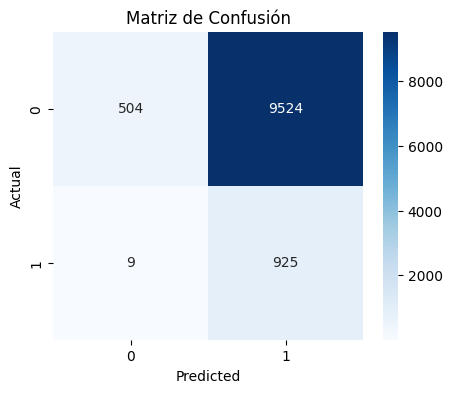

In [58]:
from sklearn.metrics import confusion_matrix

# Obtener predicciones
y_pred_prob = best_model.predict(X_test_final, batch_size=32)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir probabilidades a 0/1

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrarla con heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()
